In [1]:
import fpec.rxn_network as rn

import numpy as np
import matplotlib.pyplot as plt

### `fp_echem` usage examples
This notebook briefly walks through two example use cases of `fp echem`, one for a generic homogeneous thermochemical reaction, and another for a heterogeneous electrochemical reaction.
The input files are included in the `examples` directory.

For the first example, we look at the following pair of reactions:
- 2[A] + [B] -> 2[C]
- [C] + [A] -> [D]

After specifying reactions energies, barriers, and initial concentrations in the input file, the mass balances can be initialized, solved, and plotted.

Reading input file ... Successfully built reaction network.
Integrating balances ... Integration complete.


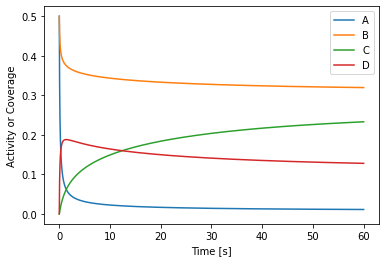

In [2]:
# parse input file and establish individual reactions
abcd_species, abcd_network = rn.create_network('ABCD.yaml', T = 298.15)

# initialize mass balances and stage the reaction network
abcd_coupled = rn.CoupledReactions(abcd_network, tmax = 60, dt = 0.01)

# integrate mass balances and deliver solution
abcd_coupled.solve() 

# quickly plot results
abcd_coupled.plot_results() 

The second example is an electrochemical reaction, where the reaction energies and barriers are potential dependent.
This is a fictitious hydrogen evolution reaction that follows a Volmer adsorption and Tafel coupling mechanism:
- [H<sup>+</sup>] + e- + [\*] -> [H\*]
- 2[H\*] -> [H<sub>2</sub>] + 2[\*]

It is critical to supply charge transfer coefficients for the energies and barriers of each reaction (respectively `dedu` and `dbdu` in the input file).
The present example evaluates steady state turnover as a function of potential.
It therefore requires a solution of an individual microkinetic model at each potential of interest.
This is achieved through a `for` loop which iterates along an array of potentials.
Three scenarios are compared to evaluate how individual reaction barriers and their dependence on potential influence expected current densities.

Text(0, 0.5, 'log$_{10}$(mA/cm$^2$)')

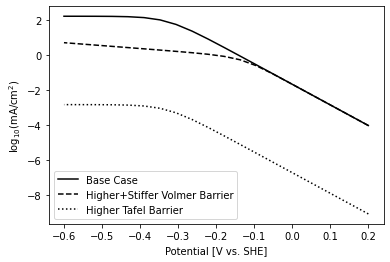

In [3]:
# set potentials to be evaluated, 20 points from +0.2 to -0.6 V vs. SHE 
potentials = np.linspace(0.2,-0.6,20)

# initialize and empty array to store steady state current densities at each potential
ss_currents = np.array([])

# for loop which solves a microkinetic model at each iteration
for u in potentials:

    # parse input file and establish individual reactions
    # U is the potential at which to solve the microkinetic model
    # the quiet flag is set to True to suppress status messages in the for loop
    vt1_species, vt1_network = rn.create_network('vt1_her.yaml', T = 298.15, U = u, quiet = True) 
    vt2_species, vt2_network = rn.create_network('vt2_her.yaml', T = 298.15, U = u, quiet = True)
    vt3_species, vt3_network = rn.create_network('vt3_her.yaml', T = 298.15, U = u, quiet = True)

    # initialize mass balances and stage the reaction network
    # fixed allows certain concentration to be held constant through integration, useful for steady state analysis
    # here, protons and H2 are considered constant, equivalent to assumption of highly efficient mass transfer
    vt1_coupled = rn.CoupledReactions(vt1_network, fixed = ['H+', 'H2'], tmax = 100, dt = 0.1) 
    vt2_coupled = rn.CoupledReactions(vt2_network, fixed = ['H+', 'H2'], tmax = 100, dt = 0.1)
    vt3_coupled = rn.CoupledReactions(vt3_network, fixed = ['H+', 'H2'], tmax = 100, dt = 0.1)

    # integrate mass balances and deliver solution
    # tolerance controls solve_ivp
    # product identifies which aspecies to target for tof calculations
    # the quiet flag is set to True to suppress status messages in the for loop    
    vt1_coupled.solve(tolerance = [1E-5, 1E-5], product = 'H2', quiet = True)
    vt2_coupled.solve(tolerance = [1E-5, 1E-5], product = 'H2', quiet = True)
    vt3_coupled.solve(tolerance = [1E-5, 1E-5], product = 'H2', quiet = True)

    # grab steady state tofs (specific to the species identified with the product flag)
    solutions = np.array([vt1_coupled.ss_tof, vt2_coupled.ss_tof, vt3_coupled.ss_tof])
    
    # convert steady state tofs to current densities
    currents = np.log10(2*2E-9*96485*1000*solutions)

    # store current in full solution array
    ss_currents = np.vstack([ss_currents, currents]) if ss_currents.size else currents

# plot it all
plt.plot(potentials, ss_currents[:,0], 'k-')
plt.plot(potentials, ss_currents[:,1], 'k--')
plt.plot(potentials, ss_currents[:,2], 'k:')
plt.legend(['Base Case', 'Higher+Stiffer Volmer Barrier', 'Higher Tafel Barrier'])
plt.xlabel('Potential [V vs. SHE]')
plt.ylabel('log$_{10}$(mA/cm$^2$)')